# Pneumonia and COVID-19 Detection with Neural Networks
By Laura Travis, Irene Ham Liu, Stephen Consoles, and Jeffery Shivers

## Introduction

One major problem in the world today is that the costs and wait times associated with health care are extremely high and continually increasing. Delayed diagnosis can prolong the time that it takes to get patients the proper treatment, and can put them at serious risk. Traditionally, diseases could only be properly diagnosed by a trained medical professional, and many of these doctors have long backlogs that can get in the way of diagnosing a disease quickly and accurately.

We see an opportunity to mitigate some of the inefficiencies associated with diagnosing a patient by training a machine-learning algorithm to do a fast and efficient screening. The more ambitious goal would be to develop a machine-learning algorithm that could fully automate the process. We do believe however, that we could substantially reduce wait times and costs associated with diagnosing a disease by automating the process even partially - perhaps by training an algorithm to do an initial screening of many patients and to flag any patients that need further review from a trained professional.

There are several important questions to explore when considering this problem:

- Is it even possible to train a machine-learning algorithm to screen very similar X-Ray images of thousands of different patients?
- Will the algorithm be able to achieve the resolution necessary to differentiate between minute features in the images that could potentially impact the diagnosis? 
- Will it be able to achieve a high level of accuracy that doctors can trust?

All of these questions are critically important because we are dealing with human lives, and even a single mis-diagnosis could have extreme consequences and bring the validity of machine learning in health care into question.

We also need to ask what type of model might be best as the foundation for this type of image classification machine-learning algorithm. Others have attempted to solve this problem mostly by using Convolutional Neural Networks. We will aim to build on these past attempts through testing our neural network with a second dataset composed of similar X-Ray images from COVID-19 patients. 

## Ethical Considerations

Before preceding, there are a number of ethical considerations that arise as we consider the role of machine learning algorithms in health care. False positives, false negatives, greed, and the participants are some areas that should be addressed. To start, let’s consider the data itself. The first dataset we will use consists of X-Ray scans of pediatric patients from one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. With a group of patients in such a specific age range, employing our ML algorithm on any new populations such as adults or the elderly may result in poor model accuracy. Any generalization to new populations would be very difficult to achieve without sampling from other groups to build upon the data we have. Additionally, the population is composed of children. While there are no obvious links in the dataset to the children themselves, we have to treat the data responsibly and question whether its right to train ML algorithms with children and whether the data was gathered with parental consent. The second dataset is less clear with the population that the X-Ray scans are comprised of, which is another issue itself.

On the one hand, using machine learning to diagnose patients may stem from trying to help people quickly and without bias, but just the opposite may be true as well. Cutting costs often comes at an expense to someone, and due to biases that could always be present in data/ML, the predictions of our machine learning algorithm should also be considered before it is used in the field. Even if we achieve high accuracy in predicting patients with pneumonia, false positives and false negatives could mean physicians make an incorrect judgement for the future treatment of the patients and could potentially cause them harm. To mitigate this, the criteria for diagnosis should be extremely strict, with any questionable X-Ray scans to be reviewed by professionals.


In [1]:
# Load general libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
!python -V 

Python 3.8.3


In [3]:
# Install libraries that may need separate installation
!pip install imutils
!pip3 install opencv-python

In [4]:
!pip3 install np_utils

In [5]:
!pip3 install opencv-python

In [6]:
!pip install opencv-python

In [7]:
# Load Machine learning libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import argparse
import os
import np_utils

import cv2
from imutils import paths
from types import SimpleNamespace

## Datasets

For this project we used two datasets:

1) “Chest X-Ray Images (Pneumonia)” dataset (IMAGE 1c in the project datasets guide). This dataset is comprised of over 6000 X-Ray images of patients, that are either healthy or have been diagnosed with cases of pneumonia. The  dataset provides us with images clearly tabulated for us to test, train and validate our model. It is worth noting that the data is somewhat limited since it does not provide metadata about the individual images (e.g. exact age and size of patient, or other health factors/indications) other than the presence of pneumonia or not. The images are organized into three subdirectories named “test”, “train” and “validate” which each have two subdirectories named “NORMAL” and “PNEUMONIA”. 

2) "COVID-19 X-Ray Dataset,” which contains X-Ray images of patients with COVID-19 related pneumonia as well as patients without pneumonia. The dataset was also pre-split by the creator into "test" and "train" subdirectories, each with "NORMAL" and "PNEUMONIA" folders to clearly delineate labels for each group. By including this set, we have tested how well our neural network stacks against a different population and can see if there any generalizations are possible.

Please see the end of the file for links to both datasets.

In [8]:
# Load current directory and dataset paths 
cdir = os.getcwd()  
#cdir = sys.path[0]  # Needed for Laura to run

paths = SimpleNamespace(**{})
paths.PNEUMONIA = 'Chest_XRay_Data/chest_xray'
paths.COVID = 'xray_dataset_covid19'


# Dataset 1: Non-COVID-19 Pneumonia Detection

### Reading in Pneumonia Data 

In [9]:
# set labels between sick and healthy patients
labels = ['PNEUMONIA', 'NORMAL']

def load_data(data_dir):
    """ Function for loading images from a folder.
    Args:
        data_dir: path/directory for the data.
    Returns:
        Numpy array of the folder's images rescaled to 150x150 pixels, in the form of [img values,label]
    """
    # reduce image size for quicker loading
    img_size = 150
    
    data = [] 
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, label])
            except Exception as e:
                print(e)
    return np.array(data)

In [10]:
# Load pneumonia data into arrays 
data = SimpleNamespace(**{})
data.train = load_data(os.path.sep.join([cdir, paths.PNEUMONIA, 'train']))
data.test = load_data(os.path.sep.join([cdir, paths.PNEUMONIA, 'test']))
data.val = load_data(os.path.sep.join([cdir, paths.PNEUMONIA, 'val']))


OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-7r9u7hyj/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-7r9u7hyj/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-7r9u7hyj/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-7r9u7hyj/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [11]:
# Check the format of an image. Each value should have an array of RGB values and a label.
data.train[0]

array([array([[18, 28, 29, ..., 13,  7,  1],
       [21, 24, 29, ..., 14,  9,  3],
       [22, 26, 32, ..., 16,  9,  2],
       ...,
       [10,  9,  8, ..., 15, 15, 15],
       [10, 10,  8, ..., 15, 15, 15],
       [10, 10,  8, ..., 15, 15, 15]], dtype=uint8),
       'PNEUMONIA'], dtype=object)

In [12]:
# Format as dataframes
df = SimpleNamespace(**{})
df.train = pd.DataFrame(data.train, columns=['image', 'label'])
df.test = pd.DataFrame(data.test, columns = ['image', 'label'])
df.val = pd.DataFrame(data.val, columns = ['image', 'label'])

df.train.head()

,image,label
0,"[[18, 28, 29, 31, 41, 42, 51, 52, 56, 62, 62, ...",PNEUMONIA
1,"[[61, 70, 76, 91, 85, 100, 89, 98, 99, 109, 10...",PNEUMONIA
2,"[[22, 33, 29, 21, 25, 20, 18, 20, 24, 21, 27, ...",PNEUMONIA
3,"[[0, 0, 0, 3, 12, 25, 32, 37, 36, 38, 43, 42, ...",PNEUMONIA
4,"[[26, 33, 42, 44, 42, 58, 72, 90, 59, 49, 49, ...",PNEUMONIA


First, we'll plot frequencies of pneumonia vs normal cases in the training, testing, and validation datasets

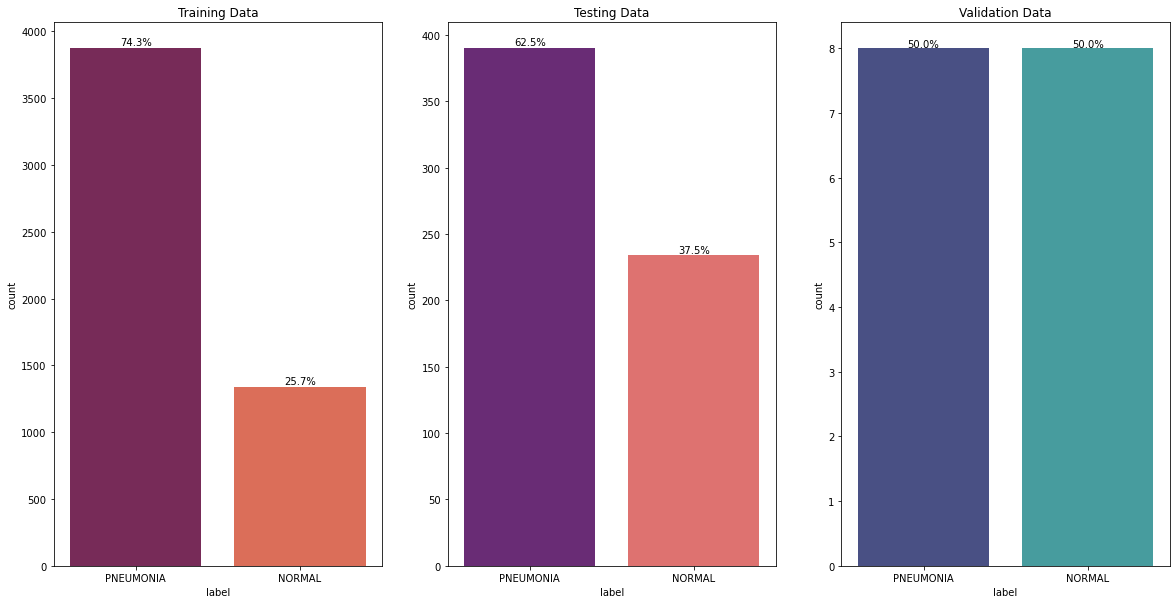

In [13]:
plt.figure(figsize = (20,10))

def plot(dataframe, title, subplot_index = 1, height_buffer = 0, palette = 'rocket'):
    plt.subplot(1, 3, subplot_index)
    total = float(len(dataframe))
    ax = sns.countplot(dataframe['label'], palette = palette) 
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + height_buffer,
            '{:1.1%}'.format(height / total),
            ha="center"
        )
    plt.title(title)

# Training
plot(df.train, 'Training Data', 1, 20)

# Testing
plot(df.test, 'Testing Data', 2, 2, 'magma')

# Validate
plot(df.val, 'Validation Data', 3, .01, 'mako');

Both the test and train datasets are imbalanced, with greater numbers of patients with pneumonia. However, they both have roughly the same percent of pneumonia to normal images between the two sets. The validation set has equal numbers of pneumonia and normal cases.

Text(0.5, 1.0, 'NORMAL')

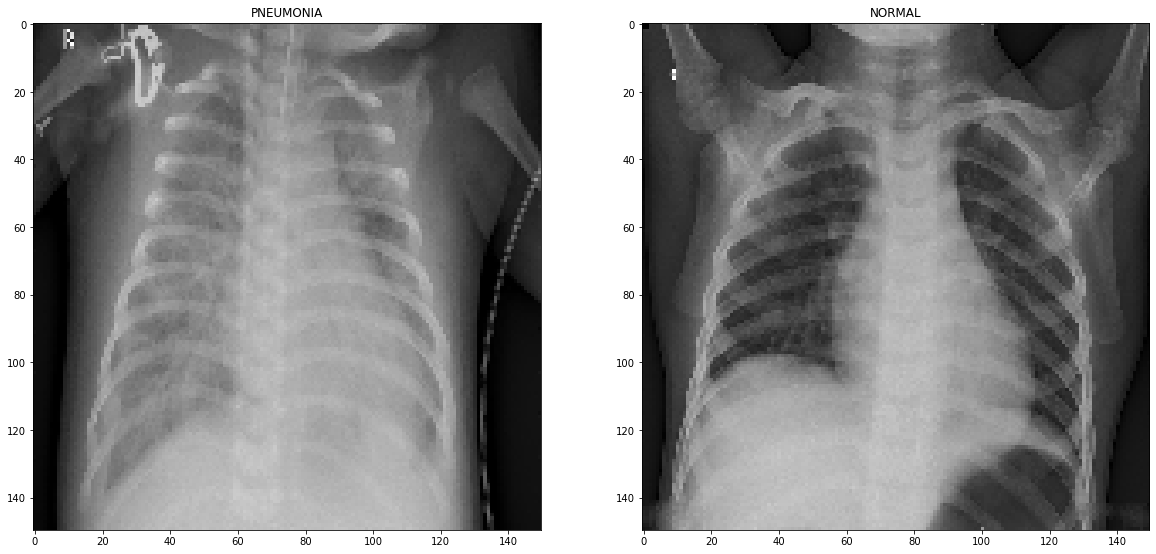

In [14]:
plt.figure(figsize = (20,10))

# example image of 'Pneumonia' case
plt.subplot(1,2,1)
plt.imshow(data.train[0][0], cmap='gray')
plt.title(data.train[0][1])

# example image of 'Normal' case
plt.subplot(1,2,2)
plt.imshow(data.train[-1][0], cmap='gray')
plt.title(data.train[-1][1])

### Pre-processing Pneumonia

In [15]:
def binary_label(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

# Split datasets into x, y
def split_x_y(dataset):
    """Splits a dataset into it's features and labels
    Args:
        dataset: a numpy array in which each datum has two columns that represent it's features and labels.
    Returns:
        A function that returns split X and y data in numpy arrays.
    """
    X = []
    y = []
    for feature, label in dataset:
        X.append(feature)
        y.append(binary_label(label))
    return(np.array(X), np.array(y))

In [16]:
# Split the datasets
X_train, y_train = split_x_y(data.train)
X_test, y_test = split_x_y(data.test)
X_val, y_val = split_x_y(data.val)

## Creating a Convolutional Neural Network

_(Steps based on https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/)_

Steps for building an image classification model using a neural network:

1. Resize the image dimensions
2. Normalize the image pixel values
3. One-Hot Encode the label column
4. Build a model architecture (Sequential) with Dense layers
5. Train the model and make predictions
6. Provide accuracy and loss plots, as well as confusion matrices

In [17]:
img_size = 150

# Resizing the images
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)
X_val = X_val.reshape(-1, img_size, img_size, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

In [18]:
# normalizing the data to help with the training
X_train /= 255
X_test /= 255
X_val /= 255

X_train[0]

array([[[0.07058824],
        [0.10980392],
        [0.11372549],
        ...,
        [0.05098039],
        [0.02745098],
        [0.00392157]],

       [[0.08235294],
        [0.09411765],
        [0.11372549],
        ...,
        [0.05490196],
        [0.03529412],
        [0.01176471]],

       [[0.08627451],
        [0.10196079],
        [0.1254902 ],
        ...,
        [0.0627451 ],
        [0.03529412],
        [0.00784314]],

       ...,

       [[0.03921569],
        [0.03529412],
        [0.03137255],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]],

       [[0.03921569],
        [0.03921569],
        [0.03137255],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]],

       [[0.03921569],
        [0.03921569],
        [0.03137255],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]]], dtype=float32)

In [19]:
# check how many images are in the training data
len(X_train)

5216

In [20]:
len(y_train)

5216

In [21]:
# one-hot encoding the labels to convert string labels to binary labels

from tensorflow.keras.utils import to_categorical

n_classes = 2
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (5216,)
Shape after one-hot encoding:  (5216, 2)


## Building the model

In [22]:
# building a linear stack of layers with the sequential model

def build_pneumonia_model():
    model = Sequential()

    # convolutional layer
    model.add(Conv2D(16, kernel_size=(3,3), 
                 strides=(1,1), 
                 padding='same', 
                 activation='relu', 
                 input_shape=(150, 150, 1)))

    model.add(MaxPool2D(pool_size=(2,2)))

    # flatten output of conv
    model.add(Flatten())

    # hidden layer
    model.add(Dense(100, activation='relu'))

    # output layer
    model.add(Dense(2, activation='softmax'))

    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    model.summary()

    return model

model_pneumonia = build_pneumonia_model()

# training the model for 10 epochs
n_epochs  = 10
batch_size = 64

history = model_pneumonia.fit(X_train, Y_train, 
                              batch_size=batch_size, 
                              epochs=n_epochs, 
                              validation_data=(X_test, Y_test), verbose = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 90000)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               9000100   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 9,000,462
Trainable params: 9,000,462
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
82/82 [==============================] - 15s 178ms/step - loss: 0.3230 - accuracy: 0.8915 - val_loss:

## Model Evaluation

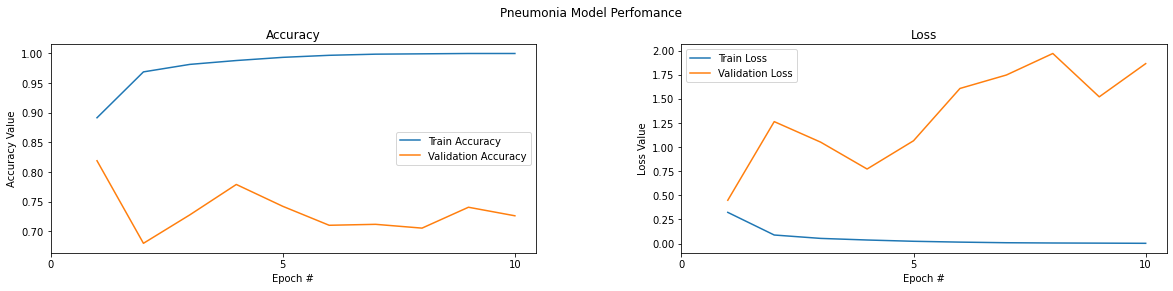

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pneumonia Model Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, n_epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, n_epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Confusion Matrices

In [24]:
#Output confusion matrix function
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Yes', 'No'], size = 16)
    plt.yticks(np.arange(2), ['Yes', 'No'], size = 16)
    plt.ylim([2, 0])
    plt.show()

In [25]:
pred_train = model_pneumonia.predict(X_train)
pred_test = model_pneumonia.predict(X_test)

pred_train = np.argmax(pred_train,-1)
pred_test= np.argmax(pred_test,-1)

true_train = np.argmax(Y_train,-1)
true_test = np.argmax(Y_test,-1)

True positive =  64
False positive =  170
False negative =  1
True negative =  389


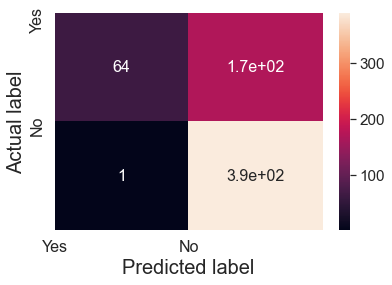

In [26]:
print_confusion_matrix(true_test,pred_test)

True positive =  1341
False positive =  0
False negative =  0
True negative =  3875


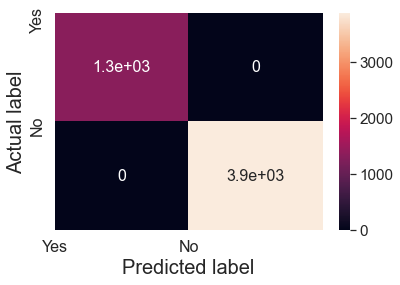

In [27]:
print_confusion_matrix(true_train,pred_train)

## Classic Pneumonia Model Results

The pneumonia model has high accuracy and low loss when performing with the training data, however when validating on the test data, the model is not as strong. The model is approximately 70% to 80% accurate in its prediction of pneumonia versus healthy X-Ray scans. Looking at the confusion matrix for this model, we can see the main source of inaccuracies is for X-Rays scans of "normal," healthy patients. While it performs very well for detecting cases of pneumonia, it often gives a false positive on normal scans, labeling them as pneumonia cases. To improve upon the model in the future and reduce the evidently overfitting issue, we would perform data augmentation to artificially extend our training set. Through adding more images artificially by altering the dataset to include slight differences, such as rotating, adding color variance, and flipping, the model may be more robust in detecting the true differences between the two groups.

# Dataset 2: COVID-19 Pneumonia Detection

## Setup

The setup, pre-processing, and model building follow the same steps as defined for the classic pneumonia model.

In [28]:
# Load covid data into arrays
covid_data = SimpleNamespace(**{})
covid_data.train = load_data(os.path.sep.join([cdir, paths.COVID, 'train']))
covid_data.test = load_data(os.path.sep.join([cdir, paths.COVID, 'test']))

In [29]:
# Format as dataframes
covid_df = SimpleNamespace(**{})
covid_df.train = pd.DataFrame(covid_data.train, columns = ['image', 'label'])
covid_df.test = pd.DataFrame(covid_data.test, columns = ['image', 'label'])

We'll quickly check some of the images in the dataset. This example of COVID-19 versus 

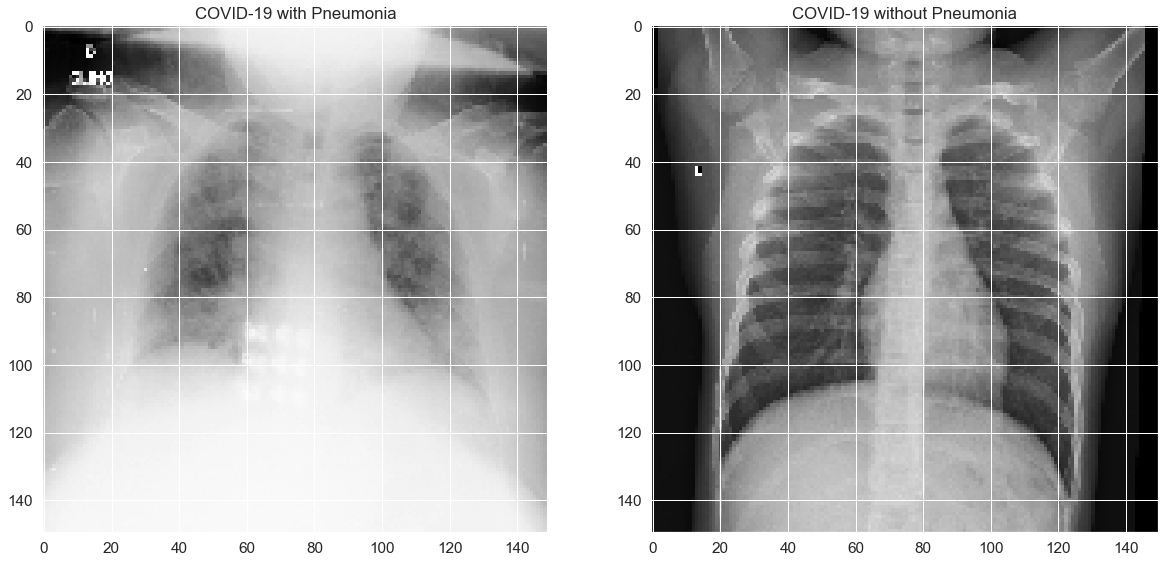

In [30]:
plt.figure(figsize = (20,10))

image_index = 0
label_index = 1

def to_title(label):
    return 'COVID-19 with' + ('out' if label == 'NORMAL' else '') + ' Pneumonia'

# example image of COVID + pneumonia case
pneumonia_case_index = 0
plt.subplot(1,2,1)
plt.imshow(covid_data.train[pneumonia_case_index][image_index], cmap='gray')
plt.title(to_title(covid_data.train[pneumonia_case_index][label_index]))

# example image of COVID (without pneumonia) case
normal_case_index = -1
plt.subplot(1,2,2)
plt.imshow(covid_data.train[normal_case_index][image_index], cmap='gray')
plt.title(to_title(covid_data.train[normal_case_index][label_index]));

## Show the frequencies of COVID vs COVID-with-pneumonia

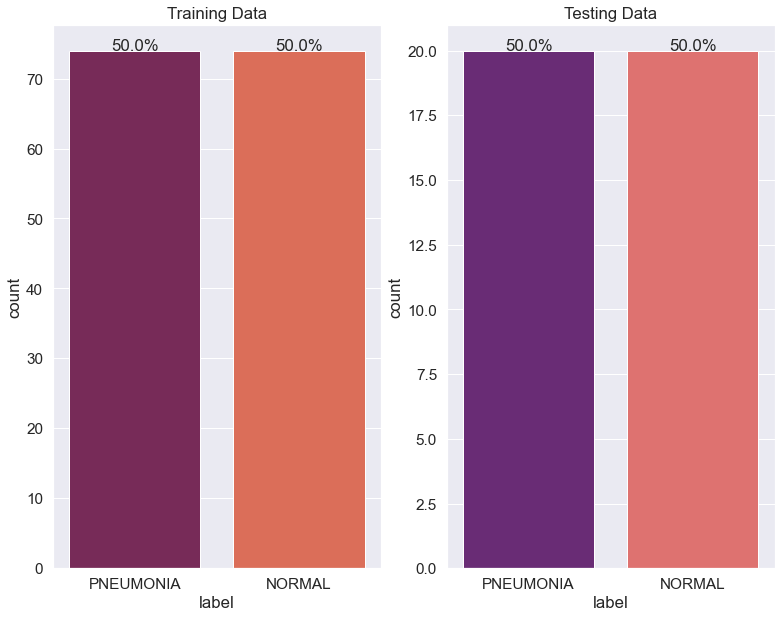

In [31]:
plt.figure(figsize = (20,10))

# Training
plot(covid_df.train, 'Training Data', 1, 0)

# Testing
plot(covid_df.test, 'Testing Data', 2, 0, 'magma')

As you can see, the datasets are very small. The train data has just over 70 images for each label, while the test data has only 20 images each. However, because the data is balanced in both for each label, we will see whether this is an improvement for a CNN model. 

In [32]:
# Split the datasets
X_train_covid, y_train_covid = split_x_y(covid_data.train)
X_test_covid, y_test_covid = split_x_y(covid_data.test)

In [33]:
# Resizing the images
X_train_covid = X_train_covid.reshape(-1, img_size, img_size, 1)
X_test_covid = X_test_covid.reshape(-1, img_size, img_size, 1)


X_train_covid = X_train_covid.astype('float32')
X_test_covid = X_test_covid.astype('float32')


X_train_covid /= 255
X_test_covid /= 255

X_train_covid[0]

array([[[0.49803922],
        [0.42352942],
        [0.41960785],
        ...,
        [0.52156866],
        [0.5254902 ],
        [0.99215686]],

       [[0.25882354],
        [0.22745098],
        [0.23921569],
        ...,
        [0.45882353],
        [0.4627451 ],
        [0.99215686]],

       [[0.04313726],
        [0.04705882],
        [0.05098039],
        ...,
        [0.41960785],
        [0.42745098],
        [0.99607843]],

       ...,

       [[0.9647059 ],
        [0.94509804],
        [0.9490196 ],
        ...,
        [0.85490197],
        [0.83137256],
        [0.99607843]],

       [[0.9647059 ],
        [0.94509804],
        [0.9529412 ],
        ...,
        [0.85490197],
        [0.8352941 ],
        [0.99607843]],

       [[0.9607843 ],
        [0.9490196 ],
        [0.9529412 ],
        ...,
        [0.8666667 ],
        [0.85490197],
        [0.99215686]]], dtype=float32)

In [34]:
# one-hot encoding the labels
n_classes = 2

print("Shape before one-hot encoding: ", y_train_covid.shape)
Y_train_covid = to_categorical(y_train_covid)
Y_test_covid = to_categorical(y_test_covid)
print("Shape after one-hot encoding: ", Y_train_covid.shape)

Shape before one-hot encoding:  (148,)
Shape after one-hot encoding:  (148, 2)


In [35]:
len(X_train_covid)

148

In [36]:
len(y_train_covid)

148

## Building the COVID-19 CNN Model

We will build another sequential model for the COVID-19 dataset below. We have chosen to build the model in a similar fashion as the classic pneumonia model to test the theory of data balance, as well to employ transfer learning later in the project. 

In [37]:
# building a linear stack of layers with the sequential model
model_covid = Sequential()

# convolutional layer
model_covid.add(Conv2D(16, kernel_size=(3,3), 
                 strides=(1,1), 
                 padding='same', 
                 activation='relu', 
                 input_shape=(150, 150, 1)))

model_covid.add(MaxPool2D(pool_size=(2,2)))

# flatten output of conv
model_covid.add(Flatten())

# hidden layer
model_covid.add(Dense(100, activation='relu'))

# output layer
model_covid.add(Dense(2, activation='softmax'))

# compiling the sequential model
model_covid.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model_covid.summary()

# training the model for 10 epochs
n_epochs  = 10
batch_size = 64

history = model_covid.fit(X_train_covid, Y_train_covid, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test_covid, Y_test_covid), verbose = 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               9000100   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 9,000,462
Trainable params: 9,000,462
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3/3 [==============================] - 0s 157ms/step - loss: 2.9871 - accuracy: 0.5135 - val_loss: 

## Model Evaluation

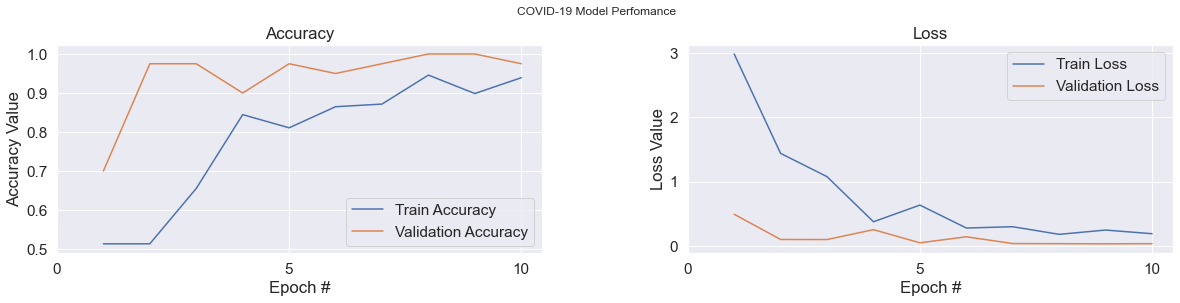

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('COVID-19 Model Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, n_epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, n_epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [39]:
pred_train_covid = model_covid.predict(X_train_covid)
pred_test_covid = model_covid.predict(X_test_covid)

pred_train_covid = np.argmax(pred_train_covid,-1)
pred_test_covid = np.argmax(pred_test_covid,-1)

true_train_covid = np.argmax(Y_train_covid,-1)
true_test_covid = np.argmax(Y_test_covid,-1)

True positive =  20
False positive =  0
False negative =  1
True negative =  19


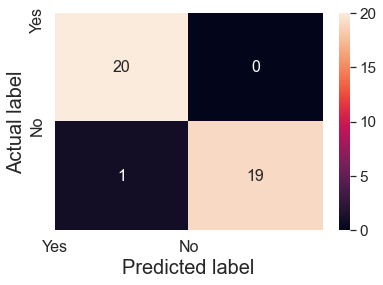

In [40]:
print_confusion_matrix(true_test_covid, pred_test_covid)

True positive =  71
False positive =  3
False negative =  3
True negative =  71


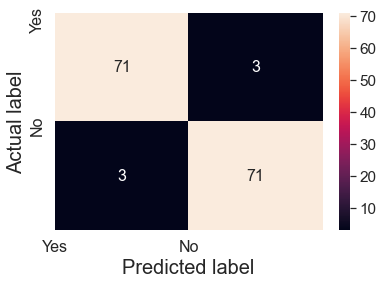

In [41]:
print_confusion_matrix(true_train_covid, pred_train_covid)

The COVID-19 model performed much better than the classic pneumonia model. On the test dataset, the model reached over 90% accurate, an impressive result. It only misclassified one image, a false negative. The result is quite promising, but we must remember the limited nature of this model due to the size of the dataset. Again, the training data was of only 150 images across the two labels, while the test data was only 40 images in total. Because of this, it is impossible to say whether the model would run as well if the dataset was expanded. Hopefully as we all learn more about the COVID-19 virus, more images will become available in the future for testing. Until then, we can perform data-augmentation as mentioned before to artificially increase our data.

# Transfer Learning Between Models 

In the next two sections, we will test each model with the opposite dataset, for example, we will test the COVID-19 on the model trained with pneumonia data (and vice versa). 

## Validating the COVID-19 Model with Pneumonia Data

In [42]:
history = model_covid.fit(X_train_covid, Y_train_covid, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test), verbose = 1)

Epoch 1/10
3/3 [==============================] - 1s 272ms/step - loss: 0.1348 - accuracy: 0.9527 - val_loss: 2.6062 - val_accuracy: 0.3846
Epoch 2/10
3/3 [==============================] - 1s 269ms/step - loss: 0.1683 - accuracy: 0.9257 - val_loss: 2.3958 - val_accuracy: 0.3926
Epoch 3/10
3/3 [==============================] - 1s 247ms/step - loss: 0.1315 - accuracy: 0.9527 - val_loss: 1.8184 - val_accuracy: 0.4054
Epoch 4/10
3/3 [==============================] - 1s 230ms/step - loss: 0.1041 - accuracy: 0.9662 - val_loss: 1.7556 - val_accuracy: 0.4071
Epoch 5/10
3/3 [==============================] - 1s 235ms/step - loss: 0.0901 - accuracy: 0.9662 - val_loss: 1.8672 - val_accuracy: 0.4006
Epoch 6/10
3/3 [==============================] - 1s 242ms/step - loss: 0.0785 - accuracy: 0.9730 - val_loss: 1.7248 - val_accuracy: 0.4103
Epoch 7/10
3/3 [==============================] - 1s 228ms/step - loss: 0.0664 - accuracy: 0.9797 - val_loss: 1.5266 - val_accuracy: 0.4359
Epoch 8/10
3/3 [====

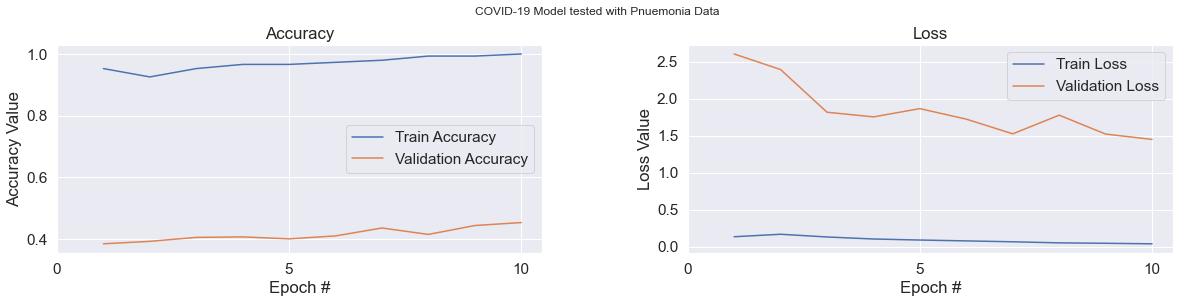

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('COVID-19 Model tested with Pnuemonia Data', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, n_epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, n_epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Validating the Pneumonia Model with COVID-19 Data

In [44]:
history = model_pneumonia.fit(X_train, Y_train, 
                              batch_size=batch_size, 
                              epochs=n_epochs, 
                              validation_data=(X_test_covid, Y_test_covid), verbose = 1)

Epoch 1/10
82/82 [==============================] - 13s 160ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.8977 - val_accuracy: 0.6750
Epoch 2/10
82/82 [==============================] - 13s 161ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.9420 - val_accuracy: 0.6250
Epoch 3/10
82/82 [==============================] - 13s 162ms/step - loss: 9.1836e-04 - accuracy: 1.0000 - val_loss: 1.9954 - val_accuracy: 0.6500
Epoch 4/10
82/82 [==============================] - 14s 173ms/step - loss: 7.5309e-04 - accuracy: 1.0000 - val_loss: 2.0190 - val_accuracy: 0.6250
Epoch 5/10
82/82 [==============================] - 15s 177ms/step - loss: 5.8874e-04 - accuracy: 1.0000 - val_loss: 2.4256 - val_accuracy: 0.6000
Epoch 6/10
82/82 [==============================] - 14s 166ms/step - loss: 5.1321e-04 - accuracy: 1.0000 - val_loss: 2.4876 - val_accuracy: 0.6000
Epoch 7/10
82/82 [==============================] - 13s 164ms/step - loss: 4.5883e-04 - accuracy: 1.0000 - val_loss: 2.2201 - 

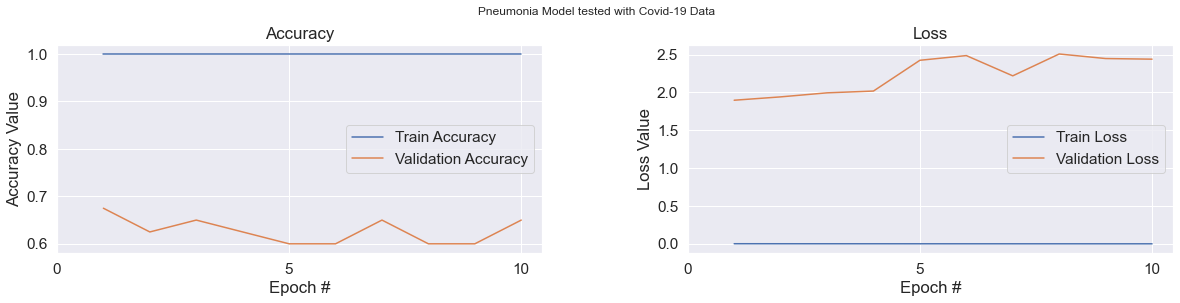

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pneumonia Model tested with Covid-19 Data', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, n_epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, n_epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Cross Validation Notes

While neither model performed exceptionally well when validated on the separate datasets, the model fit to pneumonia data was more accurate than the model fit to COVID-19. As we saw when validating the pneumonia data in the first modeling, the dataset is fairly imbalanced, which may have led to overfitting and lower accuracy scores with the training data. However, the greater amount of test images compared to the small COVID-19 dataset may have actually been the reason why it out performed in the cross validation here. The vast number of images may have had more similarity to what was found in the COVID-19 data. While we cannot speak on the similarity between classic pneumonia and pneumonia associated with COVID-19, perhaps there were some images in the classic pneumonia set that were quite alike to the new virus.

With the COVID-19 trained model and pneumonia test data, such a small training set most likely did not have images kindred enough to what was present in the classic pneumonia dataset, thus low scores of around 40%-45%. Perhaps only a small subset of the classic pneumonia was truly similar enough for the model to accuartely predict their labeling. Again, with a larger dataset that will perhaps be made available in the future, we would be able to see whether the similarities between the viruses. At this time, however, greater generalizations from either model are not recommended.

# Conclusion



We originally asked the question of whether it is even possible to train a machine-learning algorithm to aid in diagnosing pneumonia, and if so then could it be accurate enough to be trusted by doctors? While our models are not there quite yet, it appears that with more iterations and adjustments to our approach (namely better balancing and cross-validation in the original pneumonia model, and more data in the COVID model), we can achieve a higher degree of accuracy in our predictions. 
The main goal that we identified for this project was to develop a model that could provide an initial screening for medical professionals and substantially reduce the number of X-Ray images that they needed to personally review.  The pneuomonia model is very accurate in detecting cases of pneumonia but also returns many false positives.  This could be conducive to the sort of initial screening application that we had aimed for, as it would still subtstantially reduce the number of X-Ray images that the doctor needed to review, but would also prompt a doctor to review many borderline cases that turn out to be negative - adding a factor of safety to the process of diagnosing pneumonia.     



## Next Steps

In order to improve this project, it would be necessary to continue to refactor some of the code as well so that it would be easier to iterate over changes like the ones proposed. We would most likely want to namespace variables better so that we could even add / test with more models, and we'd want to clean up the code that is reused across those models.  In our proposal we identified the more ambitious goal as developing a machine-learning algorithm that could fully automate the disease diagnosis process.  This lofty objective is well beyond the scope of this project, but a more comprehensive model could potentially be achieved in the future by training with a much more expansive and diverse image set and by incorporating patient meta-data and additional layers to the algorithm.

# References



Chest X-Ray Dataset(Pneumonia). Version 2. Paul Mooney, 2018<br>
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/activity

COVID-19 Xray Dataset (Train & Test Sets). Version 1. Wei Hao Khoong, 2020<br>
https://www.kaggle.com/khoongweihao/covid19-xray-dataset-train-test-sets